In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files
import scipy.stats as stats
from scipy.optimize import curve_fit
####新项目，近5年分红去高去低*回购率排名，同时要求分红逆序数（假）不能超过6
# 爬取底层证券的现金及现金等价物，取过去两年，线性回归，计算超过转债赎回价格的概率。
# 先改成用一部分回归然后看整体的mse吧。
# 神经网络 输入价格，转股价值，转债占比，剩余年限，强赎概率，下调转股价条件(redeem_inc_cpn_fl)

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    raw_data = []
    count = 0
    
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        raw_data.append(dat_cell)
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            #pb
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = dat_cell['bond_nm'] # 转债名称
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
            lst_dat['redeem_price_ratio']  =  dat_cell['redeem_price_ratio']
            lst_dat['redeem_count_days'] =  dat_cell['redeem_count_days']
            lst_dat['redeem_real_days']  =  dat_cell['redeem_real_days']
            
            
            
  
            lst_data.append(lst_dat)
           
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data,raw_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity + 1/365/2  ####fixed dividen 0 problem
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
   
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        
    
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
 
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data,raw_data = get_dat()
pd.DataFrame.from_dict(raw_data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 380 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 416 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 10 items


Strong Sell 110072 广汇转债 98.97 169.183
111001 山玻转债 not in lists
Strong Sell 113585 寿仙转债 172.0 183.682
113633 科沃转债 not in lists
Sell 123098 一品转债 145.597 165.498
Sell 127034 绿茵转债 106.4 165.926
Strong Sell 127049 希望转2 126.863 168.130
Sell 128085 鸿达转债 161.2 166.425
Strong Sell 128096 奥瑞转债 165.683 178.583
Strong Sell 128127 文科转债 100.17 183.126

Add  113009 广汽转债 124.19 132.828
Add  128100 搜特转债 108.19 135.249
Add  110070 凌钢转债 119.04 146.728
Add  132018 G三峡EB1 130.54 147.128
Add  113011 光大转债 114.09 148.628
Add  128037 岩土转债 111.5 149.211
Add  127003 海印转债 120.713 149.246

Buy  113009 广汽转债 124.19 132.828
Buy  110070 凌钢转债 119.04 146.728
Buy  113011 光大转债 114.09 148.628
Buy  128037 岩土转债 111.5 149.211
Buy  127003 海印转债 120.713 149.246
Buy  113579 健友转债 140.48 151.438
Buy  128040 华通转债 125.222 153.414
Buy  110034 九州转债 108.24 153.662
Buy  113591 胜达转债 133.85 153.849
Buy  127042 嘉美转债 124.0 154.646
Buy  113565 宏辉转债 125.45 154.777
Buy  123002 国祯转债 118.273 154.913
today coef [3.44911182e-03 6.15146323e-02 9.377

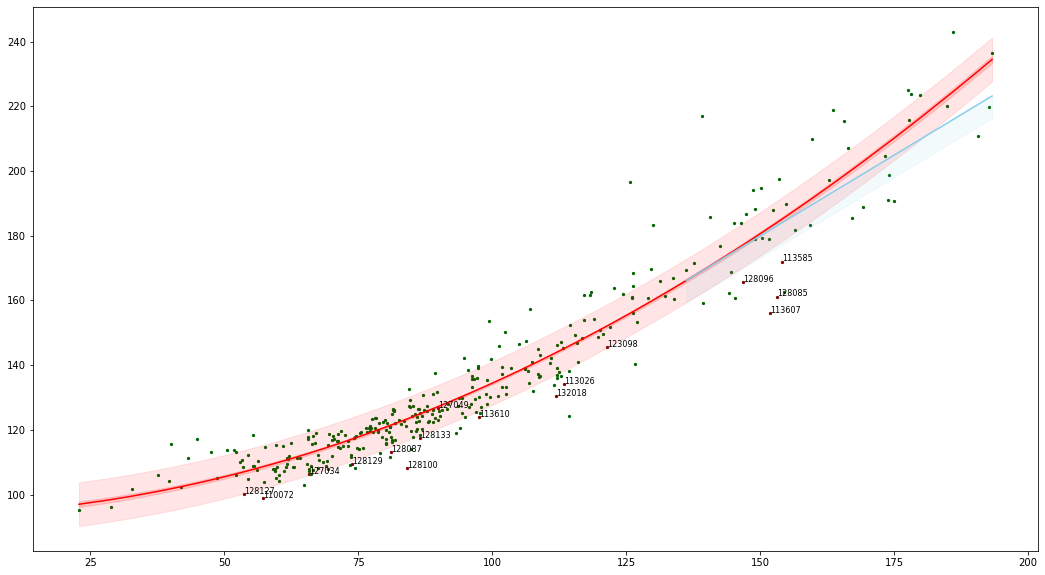

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113504,艾华转债,190.684769,210.830,10.564678,221.394678,-1.409423,220.624751,213.843965,227.405538
118000,嘉元转债,192.660401,219.630,13.998517,233.628517,1.767111,222.600383,215.816288,229.384479
113034,滨化转债,184.831574,219.990,19.021872,239.011872,5.764330,214.771556,208.000183,221.542929
113568,新春转债,193.242373,236.570,22.421391,258.991391,9.322080,223.182355,216.397272,229.967439
123084,高澜转债,186.006623,242.983,30.631370,273.614370,16.163437,215.946606,209.173390,222.719822


In [40]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

111001 山玻转债 not in lists
113633 科沃转债 not in lists
Sell 123098 一品转债 145.597 165.498 19.901 0.135
Sell 127034 绿茵转债 106.4 165.926 61.468 0.283
Strong Sell 127049 希望转2 126.863 168.130 41.267 5.353
Sell 128127 文科转债 100.17 183.126 86.789 -0.110
Sell 128133 奇正转债 117.431 153.194 35.763 -0.653

Add  113607 伟20转债 156.08 158.854 2.774 -11.289
Add  113009 广汽转债 124.19 132.828 8.638 -10.770
Add  128085 鸿达转债 161.2 166.425 5.225 -9.142
Add  132014 18中化EB 162.72 168.041 5.321 -9.035
Add  128100 搜特转债 108.19 135.249 28.673 -7.239
Add  113579 健友转债 140.48 151.438 10.958 -6.436

Strong Buy 113009 广汽转债 124.19 132.828 8.638 -10.770
Buy 132014 18中化EB 162.72 168.041 5.321 -9.035
Strong Buy 128100 搜特转债 108.19 135.249 28.673 -7.239
Strong Buy 113579 健友转债 140.48 151.438 10.958 -6.436
Strong Buy 132018 G三峡EB1 130.54 147.128 16.588 -4.856
Buy 123109 昌红转债 160.738 171.383 10.645 -4.767
Buy 113541 荣晟转债 190.63 199.605 8.975 -3.777
Buy 113039 嘉泽转债 162.14 174.593 12.453 -3.275
Buy 128103 同德转债 190.905 200.785 9.880 -3.057


In [41]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113607,伟20转债,151.867677,156.080,2.773680,158.853680,-11.288701,182.670908,175.941511,189.400305
113009,广汽转债,114.315593,124.190,8.637848,132.827848,-10.770081,145.884492,139.179774,152.589210
128085,鸿达转债,153.195796,161.200,5.224819,166.424819,-9.141804,184.150051,177.419327,190.880774
132014,18中化EB,154.499209,162.720,5.320928,168.040928,-9.034728,185.613508,178.881454,192.345563
128100,搜特转债,84.081268,108.190,28.673130,135.248601,-7.238601,123.335503,116.632567,130.038440
113579,健友转债,126.606525,140.480,10.957947,151.437947,-6.436403,156.853927,150.143864,163.563989
132018,G三峡EB1,111.967241,130.540,16.587672,147.127672,-4.856450,143.907205,137.203204,150.611205
123109,昌红转债,145.273730,160.738,10.644919,171.382919,-4.767067,175.507319,168.784048,182.230589
113541,荣晟转债,174.929937,190.630,8.975058,199.605058,-3.777201,204.869920,198.113132,211.626708


In [42]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,108.190,135.248601
132018,G三峡EB1,130.540,147.127672
113610,灵康转债,123.810,150.661122
113026,核能转债,134.220,152.567052
128087,孚日转债,113.219,152.798756
128133,奇正转债,117.431,153.194155
128129,青农转债,109.314,157.207422
113607,伟20转债,156.080,158.853680
123098,一品转债,145.597,165.498028


today quartile 167.90809587024387


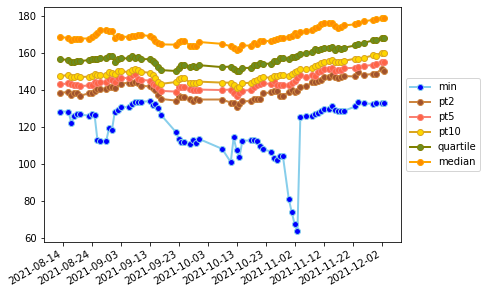

In [43]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 29.23900367062973


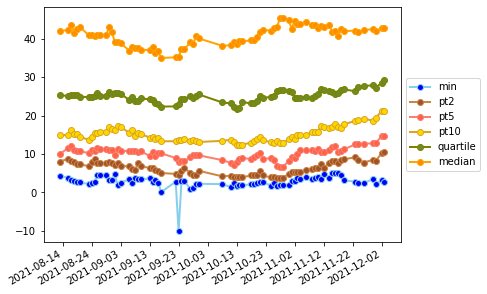

In [44]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 117.215


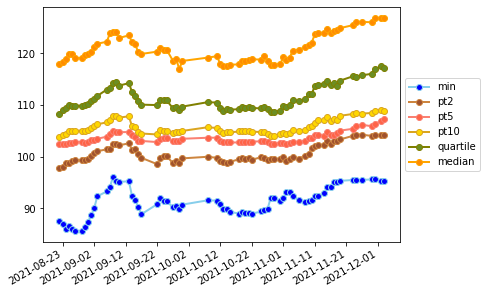

In [45]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [46]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

178.92610566257025
126.92
42.960476673604006


In [47]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113596,城地转债,28.794458,96.280,234.369893,327.366704,5.030232,98.410239,91.668844,105.151634
128062,亚药转债,22.889003,95.341,316.536278,405.260821,5.646168,96.994249,90.245583,103.742914


In [48]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y + d 
    #return a* x + b*1/x + c*y +d

In [49]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    redeem_default_prob = 0.5    #####probility of force redeem if conditons is satisfied
    time_decay_factor = 0.25  ######hyper parameter simulated time decay 
    redeem_default_days = 20 ####20 days to be forced redeem
    
    regression_data = []
    for cb_id,row in db_df.iterrows():
        name = row['name']
        price = row['price']
        value = row['new_convert_value']
        premium = row['new_premium']
        db_low = row['db_low']
        force_redeem = row['force_redeem']
        convert_value       = float(row['convert_value'])
        redeem_price_ratio  = float(row['redeem_price_ratio'])
        redeem_count_days   = int(row['redeem_count_days'])
        redeem_real_days    = int(row['redeem_real_days'])
        
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        time_to_redeem = 0
        redeem_prob = 1
        if(force_redeem == 'Y'):
            redeem_dt    = row['redeem_dt']
            expire_dt = redeem_dt     
            if(redeem_dt == None):
                time_to_redeem = redeem_default_days/365 
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_redeem = days_interval.days/365
            time_to_exp = time_to_redeem
        else:
            maturity_dt  = row['maturity_dt']
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
            redeem_prob = 0
            if(force_redeem == 'X' and convert_value >= redeem_price_ratio):
                days_to_satisfied = redeem_count_days-redeem_real_days if redeem_count_days>redeem_real_days  else 0
                days_to_satisfied += redeem_default_days
                time_to_redeem = days_to_satisfied/365
                redeem_prob = redeem_default_prob*redeem_real_days/redeem_count_days if redeem_count_days>redeem_real_days else redeem_default_prob
                #print("可能强赎:%s,%s,%s,%s,%d,redeem_prob:%.3f"%(cb_id,name,convert_value,price,redeem_real_days,redeem_prob))
                
        time_value = (1-redeem_prob) * time_to_exp ** time_decay_factor + redeem_prob * time_to_redeem ** time_decay_factor
            
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            #print("妖债:%s,%s,%s,%s"%(cb_id,name,convert_value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        regression_data.append({'id':cb_id,'name':name,'db_low':db_low,'value':value,'price':price,'time':time_to_exp,
                                'expire':expire_dt,'time_value':time_value,'redeem_prob':redeem_prob})

    
    regression_df = pd.DataFrame(regression_data)
    regression_df = regression_df.set_index(['id'])
    #y_df.sort_values('deviation',ascending=True)
    
    x  = regression_df['value']
    y  = regression_df['time_value']
    z = regression_df['price']
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

    td_data = []
    se = 0
    for cb_id,row in regression_df.iterrows():
        cb_name = row['name']
        db_low  = row['db_low']
        value      = row['value']
        time_to_exp = row['time']
        expire_dt  = row['expire']
        time_value = row['time_value']
        price = row['price']
        premium = price/value-1
        fit_price = func((value,time_value), *popt)
        
                     
        origin_time_value = time_to_exp ** time_decay_factor
        origin_fit_price = func((value,origin_time_value), *popt)
        
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_value + popt[3]
            origin_fit_price = value+intercept + popt[2] * origin_time_value + popt[3]
         
           ####set minimum fit price
        minimum_fit_price = origin_fit_price/(1+premium)
        if(fit_price < minimum_fit_price):
            fit_price = minimum_fit_price
        
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'ori_fit_price':origin_fit_price,'min_fit_price':minimum_fit_price,'expire_dt':expire_dt,'redeem_prob':row['redeem_prob']}
        td_data.append(item)
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    return popt,td_df

In [50]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,position1,position2 = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            value = td_df.loc[cb_id]['value']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            expire_dt = td_df.loc[cb_id]['expire_dt']
            redeem_prob = td_df.loc[cb_id]['redeem_prob']
            item = {'id':cb_id,'name':cb_name,'time_to_exp':time_to_exp,'value':value,'price':price,'premium':premium,
                'deviation':deviation,'expire_dt':expire_dt,'redeem_prob':redeem_prob,'position1':position1,'positon2':position2}
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('deviation',ascending=True)
    return my_df
    

In [51]:
#110048	福能转债 ! 10月6日前不提前赎回
popt,td_df = three_factor_arbitrage(db_df)

[3.50655843e-03 4.37125801e-02 1.48881357e+01 7.38725487e+01]
136.3569776645833
mse=62.027
adjuse mse=63.352


In [52]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

111001 山玻转债 not in lists
113633 科沃转债 not in lists
Sell 123098 一品转债 5.153424657534247 145.597 0.199 -5.036,redeem_prob:0.00
Strong Sell 127049 希望转2 5.9150684931506845 126.863 0.413 -1.882,redeem_prob:0.00

Add  128100 搜特转债 4.271232876712329 108.190 0.287 -12.568,redeem_prob:0.00
Add  113607 伟20转债 4.9150684931506845 156.080 0.028 -12.205,redeem_prob:0.45
Add  113579 健友转债 4.3863013698630136 140.480 0.110 -10.613,redeem_prob:0.00
Add  110072 广汇转债 4.706849315068493 98.970 0.732 -9.827,redeem_prob:0.00
Add  132014 18中化EB 1.389041095890411 162.720 0.053 -9.266,redeem_prob:0.00
Add  123109 昌红转债 5.326027397260274 160.738 0.106 -8.964,redeem_prob:0.00

Have 128100 搜特转债 4.271232876712329 108.190 0.287 -12.568,redeem_prob:0.00
Have 113607 伟20转债 4.9150684931506845 156.080 0.028 -12.205,redeem_prob:0.45
Buy 113579 健友转债 4.3863013698630136 140.480 0.110 -10.613,redeem_prob:0.00
Have 110072 广汇转债 4.706849315068493 98.970 0.732 -9.827,redeem_prob:0.00
Buy 132014 18中化EB 1.389041095890411 162.720 0.053 -9.

,name,time_to_exp,value,price,premium,deviation,expire_dt,redeem_prob,position1,positon2
id,,,,,,,,,,
128100,搜特转债,4.271233,84.081268,108.190,0.286731,-12.567611,2026-03-11,0.00,20,30
113607,伟20转债,4.915068,151.867677,156.080,0.027737,-12.205498,2026-11-01,0.45,0,0
110072,广汇转债,4.706849,57.157683,98.970,0.731526,-9.827411,2026-08-17,0.00,30,20
128085,鸿达转债,4.038356,153.195796,161.200,0.052248,-8.421764,2025-12-16,0.50,20,10
132018,G三峡EB1,2.350685,111.967241,130.540,0.165877,-7.524877,2024-04-09,0.00,30,0
113610,灵康转债,4.994521,97.602606,123.810,0.268511,-7.466563,2026-11-30,0.00,10,0
128127,文科转债,4.712329,53.627450,100.170,0.867887,-7.452961,2026-08-19,0.00,10,10
128129,青农转债,4.726027,73.741822,109.314,0.482388,-7.451733,2026-08-24,0.00,0,10
127034,绿茵转债,5.405479,65.895323,106.400,0.614682,-7.220384,2027-04-29,0.00,10,10


In [53]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,
128100,搜特转债,84.081268,4.271233,108.190,0.286731,135.248601,-12.567611,123.741329,123.741329,96.167186,2026-03-11,0.00
113607,伟20转债,151.867677,4.915068,156.080,0.027737,158.853680,-12.205498,177.778787,182.709801,177.778787,2026-11-01,0.45
113579,健友转债,126.606525,4.386301,140.480,0.109579,151.437947,-10.613462,157.160130,157.160130,141.639364,2026-04-22,0.00
110072,广汇转债,57.157683,4.706849,98.970,0.731526,169.183431,-9.827411,109.756192,109.756192,63.386982,2026-08-17,0.00
132014,18中化EB,154.499209,1.389041,162.720,0.053209,168.040928,-9.265502,179.336419,179.336419,170.276149,2023-04-24,0.00
123109,昌红转债,145.273730,5.326027,160.738,0.106449,171.382919,-8.964028,176.565369,176.565369,159.578380,2027-03-31,0.00
113614,健20转债,140.396522,0.030137,141.700,0.009284,142.628426,-8.741985,155.274033,155.274033,153.845690,2021-12-14,1.00
128085,鸿达转债,153.195796,4.038356,161.200,0.052248,166.424819,-8.421764,176.024355,182.975411,173.889974,2025-12-16,0.50
110070,凌钢转债,93.227563,4.358904,119.040,0.276876,146.727559,-8.386220,129.936784,129.936784,101.761507,2026-04-12,0.00


In [54]:
td_df.loc['123111']

name                   东财转3
value            139.267793
time_to_exp        5.342466
price                 159.2
premium            0.143121
db_low           173.512144
deviation         -6.669641
fit_price        170.576864
ori_fit_price    170.576864
min_fit_price    149.220247
expire_dt        2027-04-06
redeem_prob             0.0
Name: 123111, dtype: object

In [55]:
db_df.loc['123111']

name                        东财转3
stock_id               300059.sz
stock_name                  东方财富
price                      159.2
convert_value             147.92
premium_rt                 7.63%
rating_cd                    AA+
pb                          8.70
convert_amt_ratio           5.1%
convert_amt_ratio2          4.2%
next_put_dt           2025-04-07
put_price                100.000
put_convert_price          16.34
maturity_dt           2027-04-06
redeem_price             107.000
last_time                  5.342
force_redeem                   N
redeem_dt                   None
force_redeem_price         30.36
redeem_price_ratio       130.000
redeem_count_days             15
redeem_real_days               0
redeem_CAGR                  0.0
put_CAGR                     0.0
new_convert_value     139.267793
new_premium             0.143121
db_low                173.512144
Name: 123111, dtype: object

In [56]:
td_df[(td_df['time_to_exp']<0)]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,


In [57]:
value = 137.04*0.94
year = 0.03
limit_value = 154.03443402217655
intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
time_value = year**0.25
func((value,time_value),*popt)
#value+intercept + popt[2] * time_value + popt[3]

143.88736967183908

In [58]:
147*0.943

138.62099999999998

In [59]:
137.39/145

0.9475172413793103

In [60]:
140+151

291

In [61]:
130/138

0.9420289855072463

In [62]:
137*0.94

128.78